Notable Difference between this and V1 is (1) reshape images to 150 x 150 size and (2) ingest only equal number of training samples for each class (3) changed validation step size to a lower number

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
import os, shutil, os.path

### How Many Files in Each Set?

In [5]:
zoning_type_list = ["com_high","com_med","ind_high","ind_office_med","res_high","res_low","res_med"]
data_list = ["train_equal", "train", "train_final"]
path = "../02_Data/06_Test_Train_Val"

In [6]:
for data in data_list:
    for zoning in zoning_type_list:
        pathway = path + f"/{data}/{zoning}"
        file_count = len(os.listdir(pathway))
        print(data, file_count, zoning)

train_equal 2835 com_high
train_equal 2835 com_med
train_equal 2835 ind_high
train_equal 2835 ind_office_med
train_equal 2835 res_high
train_equal 2835 res_low
train_equal 2835 res_med
train 1728 com_high
train 3576 com_med
train 1784 ind_high
train 2024 ind_office_med
train 2160 res_high
train 2837 res_low
train 2160 res_med
train_final 3395 com_high
train_final 3395 com_med
train_final 3395 ind_high
train_final 3395 ind_office_med
train_final 3395 res_high
train_final 3395 res_low
train_final 3395 res_med


### Building The Network

In [48]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))   # "sigmoid"

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 128)       147584    
__________

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

In [50]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',    # 'binary_crossentropy', 'categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=5e-5),                # optimizers.Adam(0.0005) optimizers.RMSprop(lr=1e-4), RMSprop(lr=5e-5)  # 'rmsprop',   # "adam",  
              metrics=['acc'])                           # categorical_accuracy.          # 'acc'  

### Data Preprocessing

In [51]:
train_dir = path + "/train_final"
# validation_dir = path + "/val"

In [52]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=40,
        color_mode="grayscale",
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# validation_generator = test_datagen.flow_from_directory(
#         validation_dir,
#         target_size=(150, 150),
#         batch_size=40,
#         color_mode="grayscale",
#         class_mode='categorical')

Found 23765 images belonging to 7 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [53]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (40, 150, 150, 1)
labels batch shape: (40, 7)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [54]:
train_generator.class_indices

{'com_high': 0,
 'com_med': 1,
 'ind_high': 2,
 'ind_office_med': 3,
 'res_high': 4,
 'res_low': 5,
 'res_med': 6}

In [55]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=25) 
#     validation_data=validation_generator,
#     validation_steps=20)

Epoch 1/25
100/100 [==============================] - 7s 70ms/step - loss: 1.8043 - acc: 0.2383
Epoch 2/25
100/100 [==============================] - 6s 64ms/step - loss: 1.5692 - acc: 0.3343
Epoch 3/25
100/100 [==============================] - 6s 64ms/step - loss: 1.5016 - acc: 0.3495
Epoch 4/25
100/100 [==============================] - 6s 64ms/step - loss: 1.4759 - acc: 0.3445
Epoch 5/25
100/100 [==============================] - 6s 63ms/step - loss: 1.4665 - acc: 0.3748
Epoch 6/25
100/100 [==============================] - 6s 63ms/step - loss: 1.4517 - acc: 0.3770
Epoch 7/25
100/100 [==============================] - 6s 64ms/step - loss: 1.4198 - acc: 0.4000
Epoch 8/25
100/100 [==============================] - 6s 64ms/step - loss: 1.4248 - acc: 0.3913
Epoch 9/25
100/100 [==============================] - 6s 64ms/step - loss: 1.4014 - acc: 0.4185
Epoch 10/25
100/100 [==============================] - 6s 64ms/step - loss: 1.3952 - acc: 0.4050
Epoch 11/25
100/100 [==================

It is good practice to always save your models after training:

In [56]:
# model.save('las_vegas_CNN_Trained_12_Layers_Final_v5.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

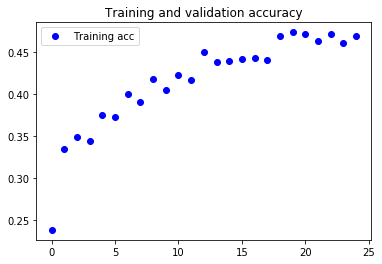

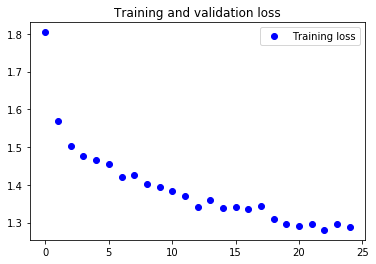

In [57]:
import matplotlib.pyplot as plt

acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.